In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from census import Census
import pandas as pd
import yaml
import os.path as osp

# Read in Census Blocks
census_blocks = gpd.read_file("zip://bg20_2.zip")
census_blocks = census_blocks[["GEOID20", "geometry"]]
census_blocks = census_blocks.to_crs(4326)

# Read in Denver 2022 rezoned election precincts
precincts = gpd.read_file("zip://election_precincts2022.zip")

# Intersect CBs w/ precincts
sjoined = gpd.overlay(census_blocks, precincts, how='intersection')

In [2]:
sjoined = sjoined.to_crs(3395)  # Need to go to a projection to compute areas using Mercator here
sjoined["intersection_area"] = sjoined["geometry"].area  # get the area of every intersection
sjoined = sjoined.to_crs(4326)  # Unproject

sjoined

,GEOID20,PRECINCT,PRECINCT_N,PRECINCT_C,CONG_DIST,SENATE_DIS,HOUSE_DIST,COUNCIL_DI,DPS_DIST,RTD_DIST,STAT_NBHD,geometry,intersection_area
0,080010150003,503.0,503,1340516503,1,34,5,9,NaN,C,Globeville,"MULTIPOLYGON (((-104.96837 39.79321, -104.9683...",1.656541e+04
1,080310035011,503.0,503,1340516503,1,34,5,9,NaN,C,Globeville,"MULTIPOLYGON (((-104.96877 39.79104, -104.9687...",7.332666e+00
2,080310015004,503.0,503,1340516503,1,34,5,9,NaN,C,Globeville,"POLYGON ((-104.98956 39.78017, -104.98956 39.7...",1.067164e+02
3,080010095532,503.0,503,1340516503,1,34,5,9,NaN,C,Globeville,"MULTIPOLYGON (((-104.99026 39.79103, -104.9902...",1.251261e+02
4,080310015003,503.0,503,1340516503,1,34,5,9,NaN,C,Globeville,"MULTIPOLYGON (((-104.99782 39.78261, -104.9978...",1.353001e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,080310014011,106.0,106,1320116106,1,32,1,7,NaN,D,Ruby Hill,"POLYGON ((-105.00673 39.69165, -105.00673 39.6...",4.509035e+05
2111,080310014012,106.0,106,1320116106,1,32,1,7,NaN,D,Ruby Hill,"POLYGON ((-105.01570 39.69106, -105.01570 39.6...",3.094036e+05
2112,080310014013,106.0,106,1320116106,1,32,1,7,NaN,D,Ruby Hill,"POLYGON ((-105.01533 39.69676, -105.01424 39.6...",5.163354e+05
2113,080310014014,106.0,106,1320116106,1,32,1,7,NaN,D,Ruby Hill,"POLYGON ((-105.01558 39.69666, -105.01558 39.6...",4.956980e+01


In [3]:
with open(osp.expanduser("~/.secrets.yaml"), 'r') as f:
    api_key = yaml.safe_load(f)['census']['api']

In [4]:
census_vars = [
    'B19025_001E',  # Aggregate household income in the past 12 months (in 2021 inflation-adjusted dollars)
    'B11016_001E',  # Total households
    'B02008_001E',  # White pop
    'B01003_001E',  # Total pop (for race)
    'B01001_001E',  # Total pop (for age)
    'B01001_018E',  # Pop 60 and 61 years Male
    'B01001_019E',  # Pop 62 and 64 years Male
    'B01001_020E',  # Pop 65 and 66 years Male
    'B01001_021E',  # Pop 67 and 69 years Male
    'B01001_022E',  # Pop 70 and 74 years Male
    'B01001_023E',  # Pop 75 and 79 years Male
    'B01001_024E',  # Pop 80 and 84 years Male
    'B01001_025E',  # Pop over 85 years Male
    'B01001_042E',  # Pop 60 and 61 years Female
    'B01001_043E',  # Pop 62 and 64 years Female
    'B01001_044E',  # Pop 65 and 66 years Female
    'B01001_045E',  # Pop 67 and 69 years Female
    'B01001_046E',  # Pop 70 and 74 years Female
    'B01001_047E',  # Pop 75 and 79 years Female
    'B01001_048E',  # Pop 80 and 84 years Female
    'B01001_049E',  # Pop over 85 years Female
]

c = Census(api_key, year=2021)
census_dicts = c.acs5.get(census_vars,
          {
            'for': 'block group:*',
            'in':'state:08 county:* tract:*'
          })
census_df = pd.DataFrame(census_dicts)
census_df

,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,B01001_022E,...,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E,state,county,tract,block group
0,22071900.0,568.0,946.0,1696.0,1696.0,26.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38.0,08,001,007801,1
1,32842500.0,717.0,620.0,2331.0,2331.0,0.0,26.0,0.0,28.0,0.0,...,13.0,0.0,51.0,46.0,9.0,0.0,08,001,007801,2
2,26700500.0,561.0,743.0,1296.0,1296.0,27.0,0.0,0.0,31.0,10.0,...,0.0,12.0,10.0,0.0,11.0,0.0,08,001,007802,1
3,27177500.0,433.0,664.0,1685.0,1685.0,0.0,0.0,0.0,0.0,143.0,...,1.0,12.0,8.0,0.0,0.0,0.0,08,001,007802,2
4,28320600.0,474.0,1072.0,1617.0,1617.0,30.0,0.0,10.0,14.0,33.0,...,6.0,0.0,7.0,64.0,0.0,0.0,08,001,007802,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,26111900.0,283.0,632.0,651.0,651.0,3.0,15.0,0.0,8.0,24.0,...,4.0,0.0,22.0,36.0,1.0,3.0,08,125,963200,1
4054,38003900.0,457.0,1034.0,1034.0,1034.0,44.0,20.0,12.0,25.0,44.0,...,14.0,31.0,31.0,37.0,4.0,8.0,08,125,963200,2
4055,36338000.0,491.0,1320.0,1320.0,1320.0,0.0,0.0,0.0,19.0,19.0,...,24.0,17.0,44.0,0.0,15.0,0.0,08,125,963200,3
4056,38210500.0,558.0,1470.0,1519.0,1519.0,52.0,53.0,34.0,13.0,20.0,...,12.0,0.0,37.0,0.0,0.0,72.0,08,125,963200,4


In [5]:
# combine columns to make a GeoId
census_df["GEOID20"] = census_df["state"] + census_df["county"] + census_df["tract"] + census_df["block group"]
census_df = census_df[["GEOID20"] + census_vars]
census_df

,GEOID20,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
0,080010078011,22071900.0,568.0,946.0,1696.0,1696.0,26.0,40.0,0.0,0.0,...,0.0,0.0,27.0,57.0,0.0,0.0,0.0,0.0,0.0,38.0
1,080010078012,32842500.0,717.0,620.0,2331.0,2331.0,0.0,26.0,0.0,28.0,...,13.0,11.0,47.0,0.0,13.0,0.0,51.0,46.0,9.0,0.0
2,080010078021,26700500.0,561.0,743.0,1296.0,1296.0,27.0,0.0,0.0,31.0,...,0.0,0.0,24.0,34.0,0.0,12.0,10.0,0.0,11.0,0.0
3,080010078022,27177500.0,433.0,664.0,1685.0,1685.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,12.0,8.0,0.0,0.0,0.0
4,080010078023,28320600.0,474.0,1072.0,1617.0,1617.0,30.0,0.0,10.0,14.0,...,0.0,0.0,0.0,0.0,6.0,0.0,7.0,64.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,081259632001,26111900.0,283.0,632.0,651.0,651.0,3.0,15.0,0.0,8.0,...,1.0,15.0,1.0,8.0,4.0,0.0,22.0,36.0,1.0,3.0
4054,081259632002,38003900.0,457.0,1034.0,1034.0,1034.0,44.0,20.0,12.0,25.0,...,5.0,16.0,4.0,19.0,14.0,31.0,31.0,37.0,4.0,8.0
4055,081259632003,36338000.0,491.0,1320.0,1320.0,1320.0,0.0,0.0,0.0,19.0,...,0.0,0.0,0.0,60.0,24.0,17.0,44.0,0.0,15.0,0.0
4056,081259632004,38210500.0,558.0,1470.0,1519.0,1519.0,52.0,53.0,34.0,13.0,...,0.0,10.0,16.0,44.0,12.0,0.0,37.0,0.0,0.0,72.0


In [6]:
# some Geos have missing incomes, isn't real data wonderful 😭
missing_2021_incomes = census_df[census_df['B19025_001E'].isna()]
missing_2021_incomes

,GEOID20,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
25,080010083541,NaN,22.0,49.0,49.0,49.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0
272,080010095024,NaN,27.0,120.0,120.0,120.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0
765,080059800001,NaN,14.0,26.0,26.0,26.0,0.0,9.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
822,080130123001,NaN,9.0,4360.0,4999.0,4999.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,080130608011,NaN,32.0,63.0,63.0,63.0,0.0,0.0,31.0,0.0,...,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296,080310021021,NaN,18.0,34.0,34.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1473,080310041101,NaN,57.0,1529.0,1981.0,1981.0,0.0,1.0,0.0,0.0,...,0.0,0.0,5.0,21.0,0.0,0.0,11.0,0.0,0.0,0.0
1942,080370005043,NaN,109.0,257.0,257.0,257.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2170,080410043004,NaN,22.0,119.0,123.0,123.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0
2983,080599808001,NaN,8.0,15.0,15.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Fill them in w/ 2019 census data

c = Census(api_key, year=2019)
census_2019_dicts = c.acs5.get(['B19025_001E'],
          {
            'for': 'block group:*',
            'in':'state:08 county:* tract:*'
          })

census_2019_df = pd.DataFrame(census_2019_dicts)
census_2019_df["GEOID20"] = census_2019_df["state"] + census_2019_df["county"] + census_2019_df["tract"] + census_2019_df["block group"]
census_2019_df = census_2019_df[["GEOID20", 'B19025_001E']].rename(columns={'B19025_001E':'B19025_001E_2019'})

census_2019_df['B19025_001E_2019'] *= 1.06 # Move 2019 dollars to 2021 dollars


joined_2019 = pd.merge(census_2019_df, census_df, on="GEOID20")
joined_2019.loc[joined_2019['B19025_001E'].isnull(), 'B19025_001E'] = joined_2019["B19025_001E_2019"]

joined_2019

,GEOID20,B19025_001E_2019,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
0,081010031032,13585172.0,14416400.0,259.0,676.0,771.0,771.0,7.0,0.0,7.0,...,0.0,5.0,8.0,5.0,0.0,4.0,13.0,0.0,8.0,0.0
1,081010006003,11977894.0,10289400.0,228.0,409.0,582.0,582.0,8.0,0.0,4.0,...,0.0,0.0,0.0,6.0,0.0,10.0,15.0,2.0,5.0,8.0
2,081010006001,9525054.0,10689100.0,306.0,260.0,406.0,406.0,20.0,25.0,3.0,...,0.0,0.0,32.0,9.0,0.0,0.0,5.0,21.0,25.0,0.0
3,081010006002,14893106.0,27017900.0,363.0,579.0,937.0,937.0,4.0,16.0,10.0,...,9.0,0.0,4.0,4.0,10.0,16.0,19.0,0.0,13.0,6.0
4,081010015002,24741036.0,28451800.0,483.0,886.0,1103.0,1103.0,5.0,12.0,20.0,...,14.0,0.0,11.0,59.0,11.0,25.0,7.0,20.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,080310002023,56094246.0,57020500.0,437.0,742.0,890.0,890.0,0.0,18.0,7.0,...,0.0,0.0,10.0,0.0,3.0,0.0,20.0,3.0,0.0,0.0
2847,080310013014,32648000.0,37310900.0,376.0,1032.0,1079.0,1079.0,0.0,0.0,0.0,...,0.0,0.0,0.0,16.0,10.0,0.0,37.0,0.0,0.0,0.0
2848,080310013021,35207688.0,59235900.0,681.0,1090.0,1595.0,1595.0,8.0,90.0,0.0,...,8.0,7.0,0.0,0.0,0.0,7.0,7.0,13.0,13.0,0.0
2849,080310013023,36855564.0,36996000.0,475.0,626.0,1372.0,1372.0,0.0,38.0,0.0,...,9.0,0.0,0.0,38.0,9.0,8.0,0.0,0.0,31.0,7.0


In [8]:
# There is still one geo with missing income 😡
joined_2019[joined_2019['B19025_001E'].isna()]

,GEOID20,B19025_001E_2019,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
721,080130123001,NaN,NaN,9.0,4360.0,4999.0,4999.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 080130123001 is in Boulder, just drop it
joined_2019.drop(joined_2019[joined_2019['B19025_001E'].isna()].index , inplace=True)
joined_2019[joined_2019['B19025_001E'].isna()]

,GEOID20,B19025_001E_2019,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E


In [10]:
# Onto more clean up, bunch of zero population geos

# 080149801001 is Glacier Park, not Denver; drop it
# 080410038021 is Air Force Academy, not Denver; drop it
# 080319801001 is Montbello & Army RM Arsenal, ahhhh
# 080019887001 is RM Arsenal, more ahhhh
# 080599800001 is US Fed Center in lakewood; also ahhhh
# 081230020132 is Dacono, not Denver; drop it
# 081019801001 is Stone City, not Denver; drop it
# 080149802001 is Glacier Park, not Denver; drop it
# 080149803001 is Glacier Park, not Denver; drop it
print(joined_2019.shape)
joined_2019[joined_2019['B01003_001E'] == 0]

(2850, 23)


,GEOID20,B19025_001E_2019,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
28,080149801001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,080410038021,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,080319801001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,080019887001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,080599800001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,081230020132,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,081019801001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1853,080149802001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2189,080149803001,-7.066667e+08,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# I checked the 2019 acs data these geos also don't have any population. I think the best thing is just to drop them
joined_2019.drop(joined_2019[joined_2019['B01003_001E'] == 0].index , inplace=True)
print(joined_2019.shape)

joined_2019[joined_2019['B01003_001E'] == 0]

(2841, 23)


,GEOID20,B19025_001E_2019,B19025_001E,B11016_001E,B02008_001E,B01003_001E,B01001_001E,B01001_018E,B01001_019E,B01001_020E,...,B01001_024E,B01001_025E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E


In [12]:
census_joined = pd.merge(sjoined, joined_2019, on = "GEOID20")
census_joined["hh_inc"] = (census_joined["B19025_001E"]/census_joined["B11016_001E"])
census_joined["wt_perc"] = (census_joined["B02008_001E"]/census_joined["B01003_001E"])
census_joined["plus_60_perc"] = ( \
    (census_joined["B01001_018E"] + 
     census_joined["B01001_019E"] + 
     census_joined["B01001_020E"] + 
     census_joined["B01001_021E"] +
     census_joined["B01001_022E"] +
     census_joined["B01001_023E"] +
     census_joined["B01001_024E"] +
     census_joined["B01001_025E"] +
     census_joined["B01001_042E"] +
     census_joined["B01001_043E"] +
     census_joined["B01001_044E"] +
     census_joined["B01001_045E"] +
     census_joined["B01001_046E"] +
     census_joined["B01001_047E"] +
     census_joined["B01001_048E"] +
     census_joined["B01001_049E"]) / census_joined["B01001_001E"])
census_joined['PRECINCT'] = census_joined['PRECINCT_N'].astype('int')
census_joined = census_joined[["PRECINCT", "GEOID20", "hh_inc", "wt_perc", "plus_60_perc", "intersection_area"]]
census_joined

,PRECINCT,GEOID20,hh_inc,wt_perc,plus_60_perc,intersection_area
0,503,080010095532,96802.773925,0.967941,0.242293,1.251261e+02
1,502,080010095532,96802.773925,0.967941,0.242293,3.655117e+02
2,503,080310015003,52950.000000,0.811611,0.018957,1.353001e+06
3,508,080310015003,52950.000000,0.811611,0.018957,1.662714e+06
4,502,080310015003,52950.000000,0.811611,0.018957,1.435905e+01
...,...,...,...,...,...,...
1315,405,080310003012,137417.628205,1.000000,0.238926,2.713846e+05
1316,411,080310003012,137417.628205,1.000000,0.238926,2.169353e+02
1317,406,080310003012,137417.628205,1.000000,0.238926,2.711951e+05
1318,408,080310004014,112549.070632,0.920621,0.223469,4.649957e+05


In [13]:
# Check for NaNs in income
census_joined[census_joined['hh_inc'].isna()]

,PRECINCT,GEOID20,hh_inc,wt_perc,plus_60_perc,intersection_area


In [14]:
# Check for NaNs in white percent
census_joined[census_joined['wt_perc'].isna()]

,PRECINCT,GEOID20,hh_inc,wt_perc,plus_60_perc,intersection_area


In [15]:
# Check for NaNs in 60+
census_joined[census_joined['plus_60_perc'].isna()]

,PRECINCT,GEOID20,hh_inc,wt_perc,plus_60_perc,intersection_area


In [16]:
# Find the total area of all intersecting polygons
area_totals = census_joined.groupby("PRECINCT").sum("intersection_area").reset_index()[["PRECINCT", "intersection_area"]].rename(columns={"intersection_area": "areas_total"})
area_totals

,PRECINCT,areas_total
0,101,1.120425e+06
1,102,1.142554e+06
2,103,1.648456e+06
3,104,1.653093e+06
4,105,1.095096e+06
...,...,...
271,924,2.217355e+05
272,925,2.076060e+06
273,926,3.521977e+00
274,927,2.806879e+05


In [17]:
# Compute weight of each CB's contribution to the total

census_joined_with_weight = pd.merge(census_joined, area_totals, on="PRECINCT")
census_joined_with_weight["weight"] = census_joined_with_weight["intersection_area"] / census_joined_with_weight["areas_total"]
census_joined_with_weight

,PRECINCT,GEOID20,hh_inc,wt_perc,plus_60_perc,intersection_area,areas_total,weight
0,503,080010095532,96802.773925,0.967941,0.242293,1.251261e+02,4.641482e+06,0.000027
1,503,080310015003,52950.000000,0.811611,0.018957,1.353001e+06,4.641482e+06,0.291502
2,503,080310002012,123848.786718,0.860020,0.138469,1.652700e+02,4.641482e+06,0.000036
3,503,080010089011,96962.500000,0.822072,0.075075,5.660269e+02,4.641482e+06,0.000122
4,503,080310015001,72138.655462,0.829091,0.122424,2.054863e+06,4.641482e+06,0.442717
...,...,...,...,...,...,...,...,...
1315,243,080310030043,179412.203791,0.915315,0.318468,6.157206e+01,1.549005e+06,0.000040
1316,243,080310040023,196498.633880,0.909774,0.324382,5.326526e+05,1.549005e+06,0.343868
1317,243,080310040022,235065.529010,0.967146,0.250513,5.068267e+05,1.549005e+06,0.327195
1318,243,080310040024,132044.805195,1.000000,0.475155,5.090592e+05,1.549005e+06,0.328636


In [18]:
# Normalize stats by weight of intersection_area

census_joined_with_weight["hh_inc"] *= census_joined_with_weight["weight"]
census_joined_with_weight["wt_perc"] *= census_joined_with_weight["weight"]
census_joined_with_weight["plus_60_perc"] *= census_joined_with_weight["weight"]
census_joined_with_weight

,PRECINCT,GEOID20,hh_inc,wt_perc,plus_60_perc,intersection_area,areas_total,weight
0,503,080010095532,2.609630,0.000026,0.000007,1.251261e+02,4.641482e+06,0.000027
1,503,080310015003,15435.033931,0.236586,0.005526,1.353001e+06,4.641482e+06,0.291502
2,503,080310002012,4.409904,0.000031,0.000005,1.652700e+02,4.641482e+06,0.000036
3,503,080010089011,11.824540,0.000100,0.000009,5.660269e+02,4.641482e+06,0.000122
4,503,080310015001,31937.016939,0.367053,0.054199,2.054863e+06,4.641482e+06,0.442717
...,...,...,...,...,...,...,...,...
1315,243,080310030043,7.131531,0.000036,0.000013,6.157206e+01,1.549005e+06,0.000040
1316,243,080310040023,67569.506320,0.312842,0.111545,5.326526e+05,1.549005e+06,0.343868
1317,243,080310040022,76912.266523,0.316445,0.081967,5.068267e+05,1.549005e+06,0.327195
1318,243,080310040024,43394.702074,0.328636,0.156153,5.090592e+05,1.549005e+06,0.328636


In [19]:
# Group all CBs for a precinct

grouped_precincts = census_joined_with_weight.groupby("PRECINCT").sum().reset_index()
grouped_precincts = grouped_precincts[['PRECINCT', "hh_inc", "wt_perc", "plus_60_perc", "intersection_area"]]
grouped_precincts

/var/folders/4x/qfxgrths1h12c7wrq6pry7lc0000gn/T/ipykernel_9744/2734860758.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_precincts = census_joined_with_weight.groupby("PRECINCT").sum().reset_index()


,PRECINCT,hh_inc,wt_perc,plus_60_perc,intersection_area
0,101,57061.220521,0.945279,0.103579,1.120425e+06
1,102,54439.946671,0.897233,0.116730,1.142554e+06
2,103,81251.261609,0.915563,0.132746,1.648456e+06
3,104,72983.878587,0.756659,0.105808,1.653093e+06
4,105,61781.367617,0.913050,0.199759,1.095096e+06
...,...,...,...,...,...
271,924,122987.267917,0.951856,0.410222,2.217355e+05
272,925,112335.823017,0.947194,0.413650,2.076060e+06
273,926,122984.352518,0.951856,0.410231,3.521977e+00
274,927,82511.845730,0.935673,0.429825,2.806879e+05


In [21]:
# Read in Prop 20 results

phgc = pd.read_csv("phgc.csv")
phgc = phgc[phgc["Contest1"] == "Referred Question 2O"]
phgc = phgc[["Precinct Leader", "Precinct N", 'Percent Range of Votes']]
phgc = phgc.rename(columns={"Precinct N": "PRECINCT", "Percent Range of Votes":"Percent"})
phgc['PRECINCT'] = phgc['PRECINCT'].astype('int')
phgc

,Precinct Leader,PRECINCT,Percent
0,No/Against,126,50-75%
1,No/Against,127,50-75%
2,No/Against,128,50-75%
3,No/Against,129,50-75%
4,No/Against,130,50-75%
...,...,...,...
296,Yes/For,529,50-75%
297,Yes/For,537,50-75%
298,No/Against,904,> 75%
299,No/Against,837,> 75%


In [24]:
# Join results with precint stats
stats_with_results = pd.merge(grouped_precincts, phgc, on='PRECINCT')
stats_with_results

,PRECINCT,hh_inc,wt_perc,plus_60_perc,intersection_area,Precinct Leader,Percent
0,101,57061.220521,0.945279,0.103579,1.120425e+06,No/Against,50-75%
1,102,54439.946671,0.897233,0.116730,1.142554e+06,No/Against,50-75%
2,103,81251.261609,0.915563,0.132746,1.648456e+06,No/Against,50-75%
3,104,72983.878587,0.756659,0.105808,1.653093e+06,No/Against,50-75%
4,105,61781.367617,0.913050,0.199759,1.095096e+06,No/Against,50-75%
...,...,...,...,...,...,...,...
271,924,122987.267917,0.951856,0.410222,2.217355e+05,No/Against,50-75%
272,925,112335.823017,0.947194,0.413650,2.076060e+06,No/Against,50-75%
273,926,122984.352518,0.951856,0.410231,3.521977e+00,No/Against,50-75%
274,927,82511.845730,0.935673,0.429825,2.806879e+05,No/Against,50-75%


In [25]:
# Join back in precinct geometries and convert to geopandas
stats_with_geom = gpd.GeoDataFrame(pd.merge(stats_with_results, precincts[["PRECINCT", "geometry"]], on='PRECINCT', how="left"))
stats_with_geom

,PRECINCT,hh_inc,wt_perc,plus_60_perc,intersection_area,Precinct Leader,Percent,geometry
0,101,57061.220521,0.945279,0.103579,1.120425e+06,No/Against,50-75%,"POLYGON ((-105.05323 39.69690, -105.05323 39.6..."
1,102,54439.946671,0.897233,0.116730,1.142554e+06,No/Against,50-75%,"POLYGON ((-105.03787 39.69676, -105.03788 39.6..."
2,103,81251.261609,0.915563,0.132746,1.648456e+06,No/Against,50-75%,"POLYGON ((-105.05323 39.69137, -105.05323 39.6..."
3,104,72983.878587,0.756659,0.105808,1.653093e+06,No/Against,50-75%,"POLYGON ((-105.03905 39.69676, -105.03881 39.6..."
4,105,61781.367617,0.913050,0.199759,1.095096e+06,No/Against,50-75%,"POLYGON ((-105.01570 39.69088, -105.01570 39.6..."
...,...,...,...,...,...,...,...,...
271,924,122987.267917,0.951856,0.410222,2.217355e+05,No/Against,50-75%,"POLYGON ((-104.91306 39.66313, -104.91504 39.6..."
272,925,112335.823017,0.947194,0.413650,2.076060e+06,No/Against,50-75%,"POLYGON ((-104.91309 39.65654, -104.91308 39.6..."
273,926,122984.352518,0.951856,0.410231,3.521977e+00,No/Against,50-75%,"POLYGON ((-104.90354 39.66763, -104.90354 39.6..."
274,927,82511.845730,0.935673,0.429825,2.806879e+05,No/Against,50-75%,"POLYGON ((-104.90716 39.65311, -104.90716 39.6..."


In [26]:
# Compute basic stats
yes_rows = stats_with_geom[stats_with_geom["Precinct Leader"] == "Yes/For"]
no_rows = stats_with_geom[stats_with_geom["Precinct Leader"] == "No/Against"]

y_mean_inc = yes_rows['hh_inc'].mean()
n_mean_inc = no_rows['hh_inc'].mean()
print(f"income y_mean: {y_mean_inc}, n_mean: {n_mean_inc}")

y_mean_wt = yes_rows['wt_perc'].mean()
n_mean_wt = no_rows['wt_perc'].mean()
print(f"wt y_mean: {y_mean_wt}, n_mean: {n_mean_wt}")

y_mean_60p = yes_rows['plus_60_perc'].mean()
n_mean_60p = no_rows['plus_60_perc'].mean()
print(f"60p y_mean: {y_mean_60p}, n_mean: {n_mean_60p}")

income y_mean: 92904.71290846536, n_mean: 119966.40824811757
wt y_mean: 0.7077155158699271, n_mean: 0.8078431681450022
60p y_mean: 0.10959666676967145, n_mean: 0.1884161345879084


Household Income Yes mean: 92904.71290846536, No mean: 119966.40824811757


Ttest_indResult(statistic=array([-3.92104295]), pvalue=array([0.00017653]))

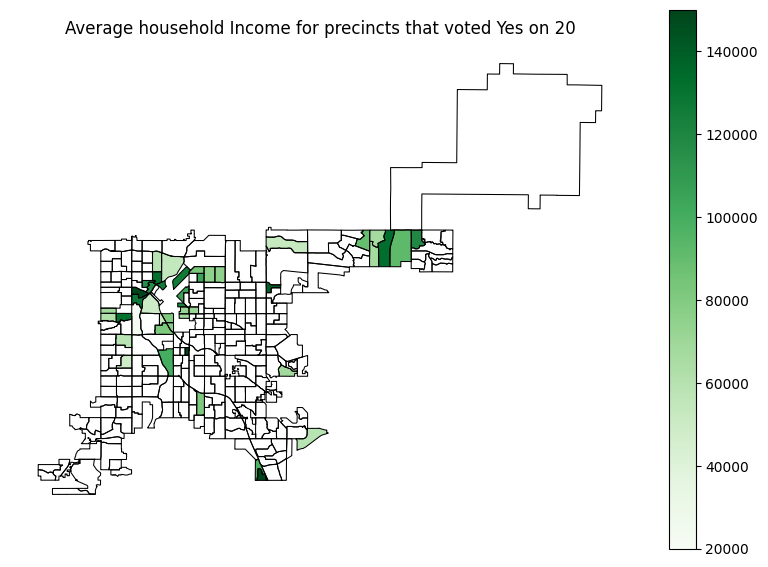

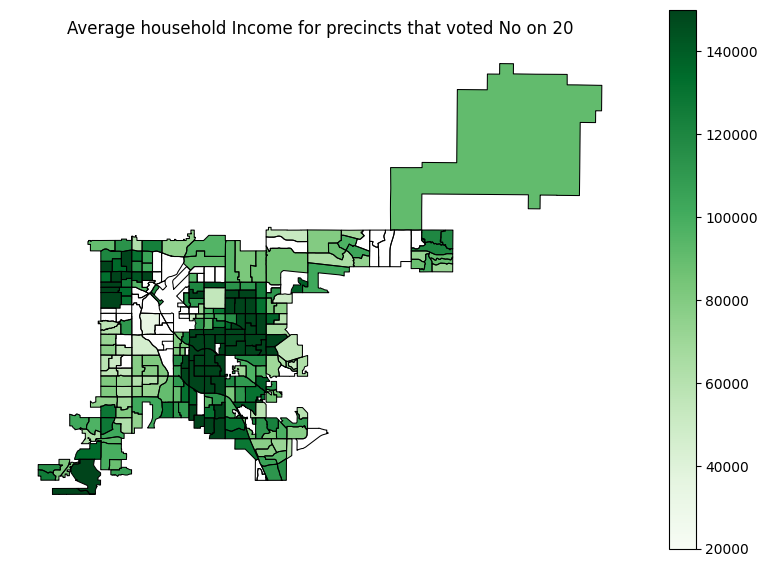

In [27]:
#Plot Average household Income
fig, ax = plt.subplots(figsize = (10,7)) 
ax.set_title("Average household Income for precincts that voted Yes on 20")
ax.set_axis_off()
yes_rows.plot("hh_inc", cmap="Greens", legend=True, vmin=20000, vmax=150000, ax=ax)
stats_with_geom.geometry.boundary.plot(color=None, edgecolor='k', linewidth = .75, ax=ax) 
fig.savefig('yes_hh.png')

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Average household Income for precincts that voted No on 20")
ax.set_axis_off()
no_rows.plot("hh_inc", cmap="Greens", legend=True, vmin=20000, vmax=150000, ax=ax)
stats_with_geom.geometry.boundary.plot(color=None, edgecolor='k', linewidth = .75, ax=ax) 
fig.savefig('no_hh.png')

print(f"Household Income Yes mean: {y_mean_inc}, No mean: {n_mean_inc}")
stats.ttest_ind(yes_rows[["hh_inc"]], no_rows[["hh_inc"]], equal_var=False)

% White Yes mean: 0.7077155158699271, No mean: 0.8078431681450022


Ttest_indResult(statistic=array([-3.56849451]), pvalue=array([0.00071978]))

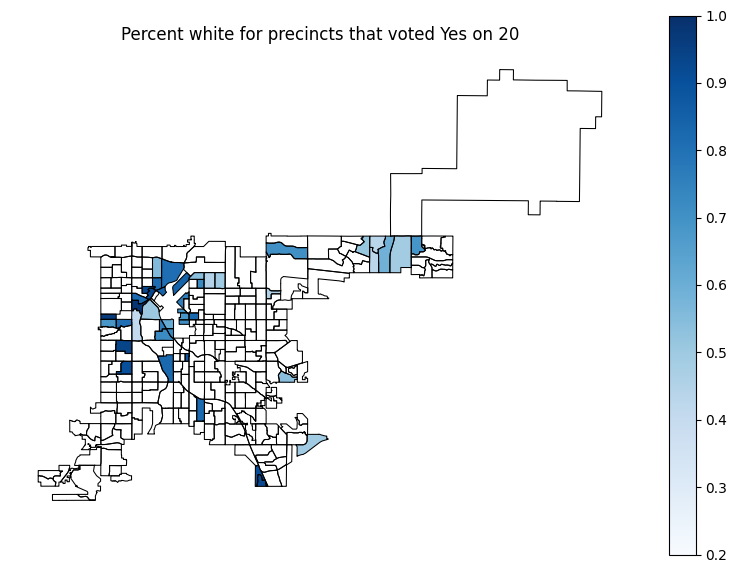

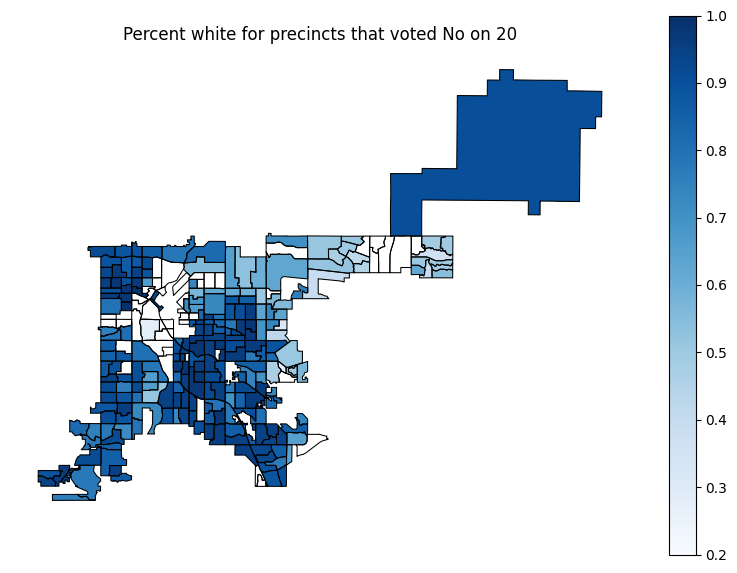

In [30]:
# Plot Percent white
fig, ax = plt.subplots(figsize = (10,7))
yes_rows.plot("wt_perc", cmap="Blues", legend=True, vmin=.2, vmax=1, ax=ax)
ax.set_title("Percent white for precincts that voted Yes on 20")
ax.set_axis_off()
stats_with_geom.geometry.boundary.plot(color=None, edgecolor='k', linewidth = .75, ax=ax)
fig.savefig('yes_wt.png')

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Percent white for precincts that voted No on 20")
ax.set_axis_off()
no_rows.plot("wt_perc", cmap="Blues", legend=True, vmin=.2, vmax=1, ax=ax)
stats_with_geom.geometry.boundary.plot(color=None, edgecolor='k', linewidth = .75, ax=ax)
fig.savefig('no_wt.png')

print(f"% White Yes mean: {y_mean_wt}, No mean: {n_mean_wt}")
stats.ttest_ind(yes_rows[["wt_perc"]], no_rows[["wt_perc"]], equal_var=False)

% 60+ Yes mean: 0.10959666676967145, No mean: 0.1884161345879084


Ttest_indResult(statistic=array([-6.6716715]), pvalue=array([4.2652934e-09]))

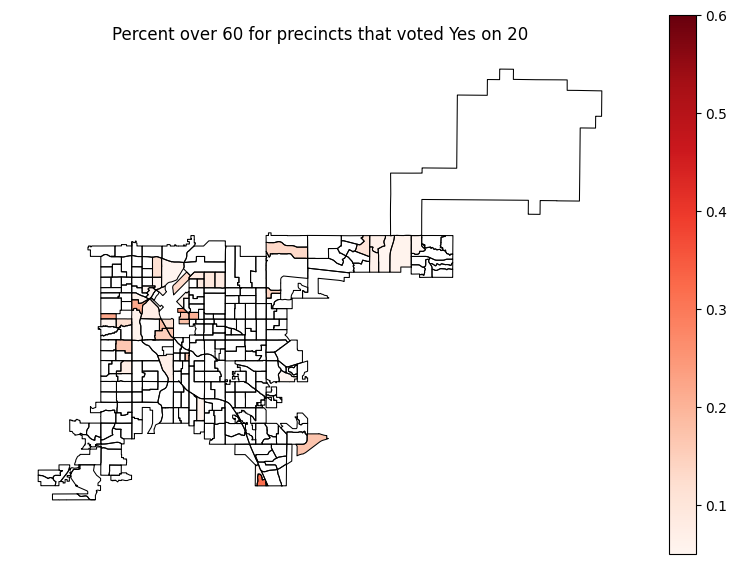

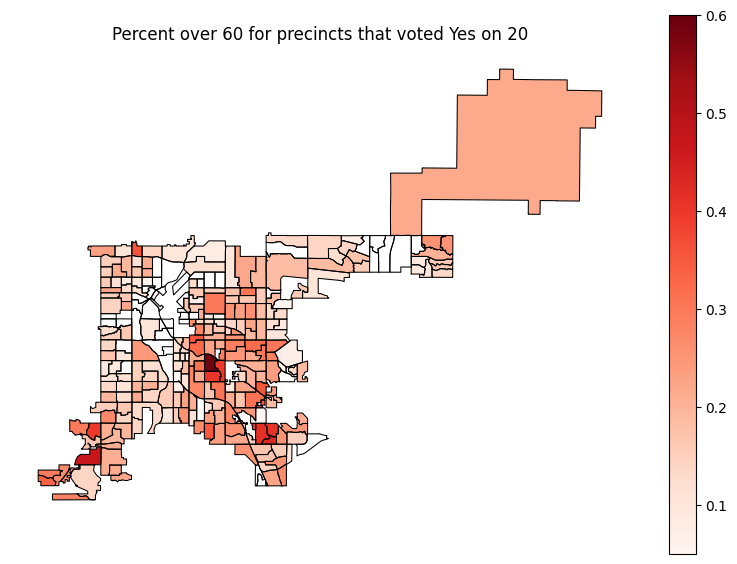

In [31]:
# Plot Percent over 60
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Percent over 60 for precincts that voted Yes on 20")
ax.set_axis_off()
yes_rows.plot("plus_60_perc", cmap="Reds", legend=True, vmin=.05, vmax=.6, ax=ax)
stats_with_geom.geometry.boundary.plot(color=None, edgecolor='k', linewidth = .75, ax=ax)
fig.savefig('yes_60+.png')

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Percent over 60 for precincts that voted Yes on 20")
ax.set_axis_off()
no_rows.plot("plus_60_perc", cmap="Reds", legend=True, vmin=.05, vmax=.6, ax=ax)
stats_with_geom.geometry.boundary.plot(color=None, edgecolor='k', linewidth = .75, ax=ax)
fig.savefig('no_60+.png')

print(f"% 60+ Yes mean: {y_mean_60p}, No mean: {n_mean_60p}")
stats.ttest_ind(yes_rows[["plus_60_perc"]], no_rows[["plus_60_perc"]], equal_var=False)

In [ ]:
# Scratch Pad Below here; Ideas that didn't work or kind of sucked

In [224]:
def to_d_percent(x):
    return x.Percent.replace('50-75%', ".625").replace('Tied % ', '0').replace('> 75%', '.875').astype('float')

income_with_for_against = income_with_for_against.assign(dPrecent=to_d_percent)
income_with_for_against

,PRECINCT,hh_inc,wt_perc,plus_60_perc,intersection_area,Precinct Leader,Percent,dPrecent
0,101,57061.220521,0.945279,0.103579,1.120425e+06,No/Against,50-75%,0.625
1,102,54439.946671,0.897233,0.116730,1.142554e+06,No/Against,50-75%,0.625
2,103,81251.261609,0.915563,0.132746,1.648456e+06,No/Against,50-75%,0.625
3,104,72983.878587,0.756659,0.105808,1.653093e+06,No/Against,50-75%,0.625
4,105,61781.367617,0.913050,0.199759,1.095096e+06,No/Against,50-75%,0.625
...,...,...,...,...,...,...,...,...
271,924,122987.267917,0.951856,0.410222,2.217355e+05,No/Against,50-75%,0.625
272,925,112335.823017,0.947194,0.413650,2.076060e+06,No/Against,50-75%,0.625
273,926,122984.352518,0.951856,0.410231,3.521977e+00,No/Against,50-75%,0.625
274,927,82511.845730,0.935673,0.429825,2.806879e+05,No/Against,50-75%,0.625


In [225]:
income_with_for_against.loc[income_with_for_against["Precinct Leader"] == "No/Against", "dPrecent"] *= -1
income_with_for_against

,PRECINCT,hh_inc,wt_perc,plus_60_perc,intersection_area,Precinct Leader,Percent,dPrecent
0,101,57061.220521,0.945279,0.103579,1.120425e+06,No/Against,50-75%,-0.625
1,102,54439.946671,0.897233,0.116730,1.142554e+06,No/Against,50-75%,-0.625
2,103,81251.261609,0.915563,0.132746,1.648456e+06,No/Against,50-75%,-0.625
3,104,72983.878587,0.756659,0.105808,1.653093e+06,No/Against,50-75%,-0.625
4,105,61781.367617,0.913050,0.199759,1.095096e+06,No/Against,50-75%,-0.625
...,...,...,...,...,...,...,...,...
271,924,122987.267917,0.951856,0.410222,2.217355e+05,No/Against,50-75%,-0.625
272,925,112335.823017,0.947194,0.413650,2.076060e+06,No/Against,50-75%,-0.625
273,926,122984.352518,0.951856,0.410231,3.521977e+00,No/Against,50-75%,-0.625
274,927,82511.845730,0.935673,0.429825,2.806879e+05,No/Against,50-75%,-0.625


In [226]:
from sklearn.linear_model import LinearRegression

0.05025584800589622


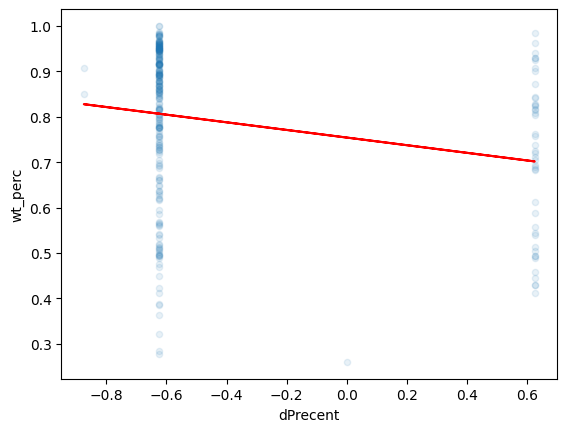

In [227]:
lin = LinearRegression()  # create object for the class
lin.fit(income_with_for_against[['dPrecent']], income_with_for_against['wt_perc'])  # perform linear regression
Y_pred = lin.predict(income_with_for_against[['dPrecent']])  # make predictions

print(lin.score(income_with_for_against[['dPrecent']], income_with_for_against['wt_perc']))

ax = income_with_for_against.plot.scatter(x='dPrecent', y='wt_perc', alpha=.1)
ax.plot(income_with_for_against['dPrecent'], lin.predict(income_with_for_against[['dPrecent']]), c='r')

In [228]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

<Axes: xlabel='PRECINCT'>

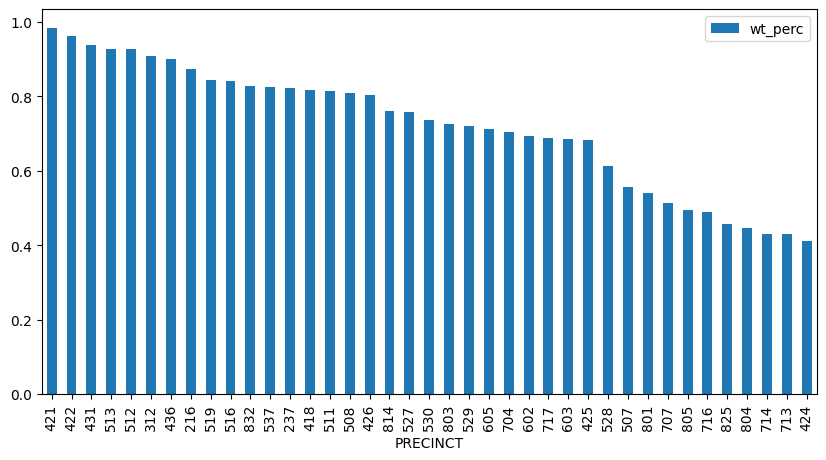

In [229]:
yes_wt = yes_rows[["PRECINCT", "wt_perc"]].sort_values("wt_perc", ascending=False)
yes_wt.plot.bar(x='PRECINCT', y='wt_perc', rot=90)

<Axes: xlabel='PRECINCT'>

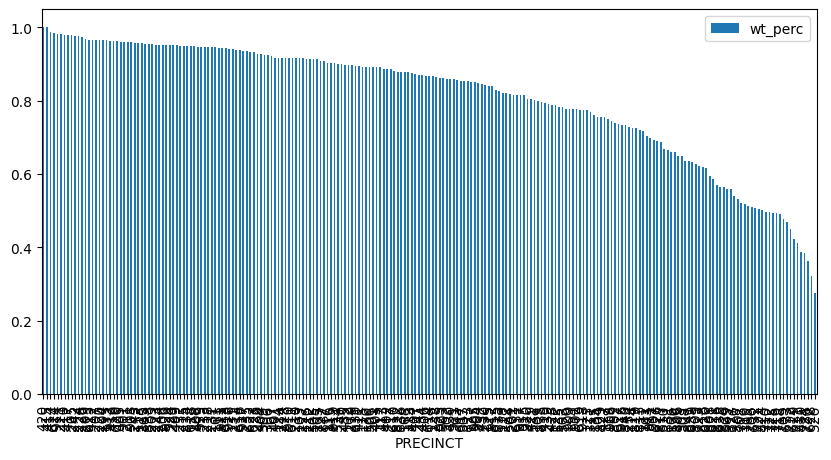

In [230]:
no_wt = no_rows[["PRECINCT", "wt_perc"]].sort_values("wt_perc", ascending=False)
no_wt.plot.bar(x='PRECINCT', y='wt_perc', rot=90)